# WeNet Evaluation On Stuttering

1. Turn original transcripts into dataframes
2. Read generated transcript dataframes
3. Get Error & Stuttering count
4. Get Error & Stuttering Type ==> show which Stuttering type is more prone to error
5. Calculate Correlation Score
6. Generate Heatmap
7. Summarize Trend

*** 

### Error Metrics
1. Net / Total Word Error Rate
2. Word Error Rate Specific After Cleaning other Stuttering Type Annotations

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [1]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


---

## Word Error Rate

Objectives:
* split sequence into characters
* count:
    * deletion: missing words
    * substitutions: wrongly recognized words
    * insertions: extra words

In [3]:
def wer(candidate, reference):
    """
    Parameter(s)
    ------------
    candidate ==> generated transcript
    reference ==> dataset transcript
    """
    
    candidate_tokens = list(candidate)
    reference_tokens = list(reference)
    
    cand_len = len(candidate_tokens)
    ref_len = len(reference_tokens)
    
    dist_mat = np.zeros((ref_len, cand_len), dtype=int)
    
    for i in range(ref_len):
        dist_mat[i][0] = i
    for j in range(cand_len):
        dist_mat[0][j] = j
        
    for i in range(1, ref_len):
        for j in range(1, cand_len):
            if (candidate_tokens[j - 1] == reference_tokens[i - 1]):
                cost = 0
            else:
                cost = 1
                
            dist_mat[i][j] = min(
                dist_mat[i-1][j] + 1,
                dist_mat[i][j-1] + 1,
                dist_mat[i-1][j-1] + cost
            )
            # print(dist_mat)
            
    wer = dist_mat[-1][-1] / len(reference_tokens)
    return wer

***

## Imports and Data Ingestion

In [2]:
import pandas as pd
import numpy as np
import scipy
import os
from tqdm import tqdm
import re
import sys

In [5]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 
net_aigenerated_data_wenet = pd.read_csv("/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/WeNet.csv", delimiter=",")

del net_aigenerated_data_wenet[net_aigenerated_data_wenet.columns[0]]

In [6]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [7]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [8]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [9]:
net_aigenerated_data_wenet

,Filename,Start_time,End_time,WeNet
0,D0001_A,2081.540000,2109.650000,我说出来就比较地需要时间然后那个识别的他的不就是他等你一会你那个话还没有说完的还没有说出来的...
1,D0001_A,790.130000,796.580000,第四句有我我说的话
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评分是不怎么好的就因为评评论区的那那些人他们都在说拿到号做好惨的那个就那么勤奋...
3,D0001_A,2016.780000,2035.673559,很精准对讯飞语音还是讯飞助手来着就我记得他是叫讯飞我之前就是他
4,D0001_A,1682.670000,1709.110000,一个个是叫啥来的我忘了就是出现了这一个人然后呢他他就射了一把剑然后就就把那个拿二号给长杀了就...
...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已
37249,P0070,2782.496000,2783.706000,杨幂的电影
37250,P0070,2995.296000,2998.116000,你好米娅今天柴油价怎么样
37251,P0070,2604.066000,2606.656000,单曲循环歌曲琉璃光之歌


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in `net_data` and AI predicted transcriptions in `net_aigenerated_data_wenet`**

***

## WER Analysis

In [10]:
na_count_large = 0
na_count_cleaned = 0
for index, row in tqdm(net_aigenerated_data_wenet.iterrows(), total=len(net_aigenerated_data_wenet)):
    
    mask_large = (
        (net_aigenerated_data_wenet["Filename"] == row["Filename"]) &
        (net_aigenerated_data_wenet["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_wenet.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    wenet = large_row["WeNet"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(wenet) or not isinstance(wenet, str):
        print("Skipping due to missing or non-string WeNet.")
        na_count_large = na_count_large + 1
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        na_count_cleaned = na_count_cleaned + 1
        continue

    try:
        
        wer_value = wer(wenet, cleaned_transcript)
        
        net_aigenerated_data_wenet.loc[mask_large, "WER"] = wer_value
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_wenet.loc[mask_large, "Stutterance_Count"] = stutterance_count

        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_wenet.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)
        
net_aigenerated_data_wenet = net_aigenerated_data_wenet.assign(NA_Count=na_count_large)
net_aigenerated_data_wenet = net_aigenerated_data_wenet.assign(NA_Cleaned_Count=na_count_cleaned)

  2%|▏         | 704/37253 [00:04<04:32, 134.12it/s]

Skipping due to missing or non-string WeNet.


  4%|▎         | 1356/37253 [00:08<04:07, 144.75it/s]

Skipping due to missing or non-string WeNet.


  4%|▍         | 1447/37253 [00:09<04:06, 144.98it/s]

Skipping due to missing or non-string WeNet.


  5%|▍         | 1854/37253 [00:12<03:41, 159.72it/s]

Skipping due to missing or non-string WeNet.
Skipping: One of the rows is empty.


  6%|▌         | 2157/37253 [00:14<03:44, 156.07it/s]

Skipping due to missing or non-string WeNet.


  6%|▌         | 2206/37253 [00:14<03:42, 157.45it/s]

Skipping due to missing or non-string WeNet.


  7%|▋         | 2732/37253 [00:18<03:42, 154.97it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 10%|█         | 3843/37253 [00:26<03:17, 169.42it/s]

Skipping due to missing or non-string WeNet.


 11%|█         | 4056/37253 [00:27<03:15, 169.50it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 11%|█         | 4128/37253 [00:27<03:12, 171.89it/s]

Skipping due to missing or non-string WeNet.


 12%|█▏        | 4452/37253 [00:29<03:10, 171.81it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 12%|█▏        | 4607/37253 [00:30<03:26, 158.05it/s]

Skipping due to missing or non-string WeNet.


 13%|█▎        | 4760/37253 [00:31<03:17, 164.81it/s]

Skipping due to missing or non-string WeNet.


 14%|█▎        | 5111/37253 [00:33<03:02, 176.09it/s]

Skipping due to missing or non-string WeNet.


 14%|█▍        | 5235/37253 [00:34<03:20, 160.09it/s]

Skipping due to missing or non-string WeNet.


 14%|█▍        | 5284/37253 [00:34<03:27, 154.08it/s]

Skipping due to missing or non-string WeNet.


 14%|█▍        | 5332/37253 [00:35<03:29, 152.53it/s]

Skipping due to missing or non-string WeNet.


 16%|█▌        | 5811/37253 [00:38<03:45, 139.22it/s]

Skipping due to missing or non-string WeNet.


 16%|█▌        | 5925/37253 [00:39<03:13, 161.51it/s]

Skipping due to missing or non-string WeNet.


 17%|█▋        | 6266/37253 [00:41<03:13, 159.87it/s]

Skipping due to missing or non-string WeNet.


 17%|█▋        | 6301/37253 [00:41<03:09, 163.06it/s]

Skipping due to missing or non-string WeNet.


 18%|█▊        | 6762/37253 [00:44<03:29, 145.84it/s]

Skipping due to missing or non-string WeNet.


 19%|█▉        | 7165/37253 [00:47<02:57, 169.36it/s]

Skipping due to missing or non-string WeNet.


 19%|█▉        | 7233/37253 [00:47<03:08, 159.67it/s]

Skipping due to missing or non-string WeNet.


 20%|██        | 7491/37253 [00:49<03:11, 155.26it/s]

Skipping due to missing or non-string WeNet.


 20%|██        | 7539/37253 [00:49<03:15, 152.28it/s]

Skipping due to missing or non-string WeNet.


 21%|██        | 7902/37253 [00:52<03:05, 158.38it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8125/37253 [00:53<02:50, 171.17it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8210/37253 [00:54<03:09, 152.89it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8242/37253 [00:54<03:09, 152.79it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 22%|██▏       | 8307/37253 [00:54<03:05, 156.22it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8371/37253 [00:55<03:05, 155.38it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 23%|██▎       | 8404/37253 [00:55<03:05, 155.43it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 23%|██▎       | 8527/37253 [00:55<02:46, 172.36it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 23%|██▎       | 8629/37253 [00:56<03:00, 158.53it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 24%|██▎       | 8787/37253 [00:57<03:19, 142.94it/s]

Skipping due to missing or non-string WeNet.


 24%|██▍       | 8849/37253 [00:58<03:16, 144.32it/s]

Skipping due to missing or non-string WeNet.


 24%|██▍       | 9049/37253 [00:59<03:08, 149.56it/s]

Skipping due to missing or non-string WeNet.


 25%|██▌       | 9386/37253 [01:01<03:19, 139.94it/s]

Skipping due to missing or non-string WeNet.


 28%|██▊       | 10315/37253 [01:07<02:43, 165.17it/s]

Skipping due to missing or non-string WeNet.


 28%|██▊       | 10488/37253 [01:08<02:56, 151.74it/s]

Skipping: One of the rows is empty.


 29%|██▉       | 10869/37253 [01:11<02:38, 166.44it/s]

Skipping due to missing or non-string WeNet.


 29%|██▉       | 10986/37253 [01:12<02:51, 152.97it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 30%|███       | 11287/37253 [01:14<02:49, 153.08it/s]

Skipping due to missing or non-string WeNet.


 31%|███       | 11598/37253 [01:16<02:44, 155.80it/s]

Skipping due to missing or non-string WeNet.


 33%|███▎      | 12151/37253 [01:19<02:39, 157.48it/s]

Skipping due to missing or non-string WeNet.


 33%|███▎      | 12218/37253 [01:20<02:33, 163.57it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 33%|███▎      | 12318/37253 [01:20<02:47, 149.23it/s]

Skipping due to missing or non-string WeNet.


 34%|███▍      | 12736/37253 [01:23<02:35, 157.26it/s]

Skipping due to missing or non-string WeNet.


 35%|███▍      | 12959/37253 [01:24<02:45, 146.56it/s]

Skipping due to missing or non-string WeNet.


 35%|███▌      | 13114/37253 [01:25<02:45, 145.56it/s]

Skipping due to missing or non-string WeNet.


 35%|███▌      | 13160/37253 [01:26<02:45, 145.32it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 36%|███▌      | 13271/37253 [01:26<02:37, 152.26it/s]

Skipping due to missing or non-string WeNet.


 38%|███▊      | 13985/37253 [01:31<02:40, 145.36it/s]

Skipping due to missing or non-string WeNet.


 38%|███▊      | 14108/37253 [01:32<02:15, 170.96it/s]

Skipping due to missing or non-string WeNet.


 38%|███▊      | 14216/37253 [01:32<02:14, 171.61it/s]

Skipping due to missing or non-string WeNet.


 39%|███▊      | 14389/37253 [01:34<02:26, 155.61it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 40%|███▉      | 14748/37253 [01:36<02:11, 171.69it/s]

Skipping due to missing or non-string WeNet.


 42%|████▏     | 15662/37253 [01:41<01:55, 187.67it/s]

Skipping due to missing or non-string WeNet.


 45%|████▍     | 16610/37253 [01:46<01:50, 187.46it/s]

Skipping due to missing or non-string WeNet.


 47%|████▋     | 17509/37253 [01:51<01:44, 188.35it/s]

Skipping due to missing or non-string WeNet.


 48%|████▊     | 17874/37253 [01:53<01:42, 188.21it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 48%|████▊     | 18029/37253 [01:54<01:42, 188.22it/s]

Skipping due to missing or non-string WeNet.


 51%|█████     | 19090/37253 [01:59<01:36, 189.15it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 52%|█████▏    | 19264/37253 [02:00<01:35, 189.08it/s]

Skipping due to missing or non-string WeNet.


 54%|█████▎    | 19999/37253 [02:04<01:31, 188.82it/s]

Skipping due to missing or non-string WeNet.


 57%|█████▋    | 21277/37253 [02:11<01:24, 189.00it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 57%|█████▋    | 21316/37253 [02:11<01:24, 189.56it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21547/37253 [02:12<01:23, 187.71it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21623/37253 [02:13<01:23, 187.65it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21700/37253 [02:13<01:23, 186.48it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21758/37253 [02:14<01:22, 187.97it/s]

Skipping due to missing or non-string WeNet.


 63%|██████▎   | 23435/37253 [02:22<01:13, 189.14it/s]

Skipping due to missing or non-string WeNet.


 66%|██████▋   | 24724/37253 [02:29<01:07, 185.89it/s]

Skipping due to missing or non-string WeNet.


 67%|██████▋   | 24857/37253 [02:30<01:06, 187.36it/s]

Skipping due to missing or non-string WeNet.


 67%|██████▋   | 25085/37253 [02:31<01:05, 186.55it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 81%|████████  | 30112/37253 [02:58<00:37, 188.31it/s]

Skipping due to missing or non-string WeNet.


 81%|████████  | 30265/37253 [02:59<00:37, 188.06it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 82%|████████▏ | 30379/37253 [03:00<00:36, 188.15it/s]

Skipping due to missing or non-string WeNet.


 82%|████████▏ | 30703/37253 [03:01<00:35, 186.81it/s]

Skipping due to missing or non-string WeNet.


 83%|████████▎ | 30761/37253 [03:02<00:34, 188.00it/s]

Skipping due to missing or non-string WeNet.


 91%|█████████▏| 34081/37253 [03:19<00:16, 189.21it/s]

Skipping: One of the rows is empty.
Skipping: One of the rows is empty.


 93%|█████████▎| 34595/37253 [03:22<00:14, 187.36it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [03:36<00:00, 171.89it/s]


In [11]:
net_aigenerated_data_wenet

,Filename,Start_time,End_time,WeNet,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count
0,D0001_A,2081.540000,2109.650000,我说出来就比较地需要时间然后那个识别的他的不就是他等你一会你那个话还没有说完的还没有说出来的...,0.226804,1.0,100,0
1,D0001_A,790.130000,796.580000,第四句有我我说的话,0.500000,1.0,100,0
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评分是不怎么好的就因为评评论区的那那些人他们都在说拿到号做好惨的那个就那么勤奋...,0.203125,10.0,100,0
3,D0001_A,2016.780000,2035.673559,很精准对讯飞语音还是讯飞助手来着就我记得他是叫讯飞我之前就是他,0.210526,7.0,100,0
4,D0001_A,1682.670000,1709.110000,一个个是叫啥来的我忘了就是出现了这一个人然后呢他他就射了一把剑然后就就把那个拿二号给长杀了就...,0.250000,8.0,100,0
...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,100,0
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,100,0
37250,P0070,2995.296000,2998.116000,你好米娅今天柴油价怎么样,0.266667,0.0,100,0
37251,P0070,2604.066000,2606.656000,单曲循环歌曲琉璃光之歌,0.083333,0.0,100,0


In [12]:
net_aigenerated_data_wenet.to_csv('net_aigenerated_data_wenet_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Word Error Rate

In [3]:
## Load data from csv if starting here

net_aigenerated_data_wenet = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wenet/net_aigenerated_data_wenet_performance_stu.csv', delimiter=',')

In [4]:
import matplotlib.pyplot as plt

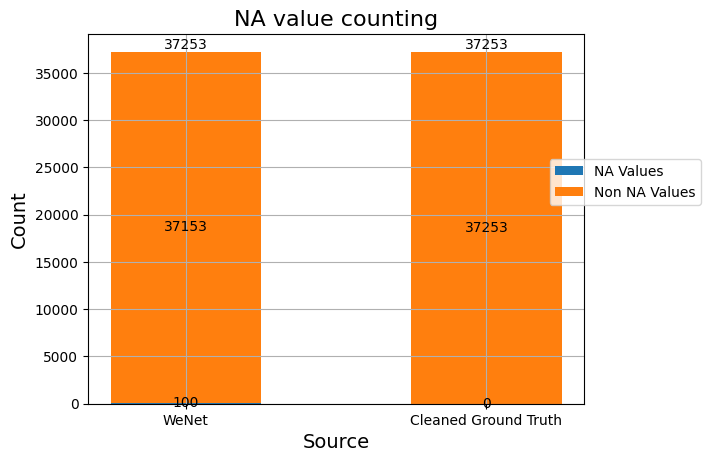

In [5]:
## Null value plots

nonnull_count_large = net_aigenerated_data_wenet["NA_Count"].count() - net_aigenerated_data_wenet.iloc[0]["NA_Count"]
null_count_large = net_aigenerated_data_wenet.iloc[0]["NA_Count"]

nonnull_count_cleaned = net_aigenerated_data_wenet["NA_Cleaned_Count"].count() - net_aigenerated_data_wenet.iloc[0]["NA_Cleaned_Count"]
null_count_cleaned = net_aigenerated_data_wenet.iloc[0]["NA_Cleaned_Count"]


data = {
    "NA Values": [null_count_large, null_count_cleaned],
    "Non NA Values": [nonnull_count_large, nonnull_count_cleaned],
}

species = (
    "WeNet",
    "Cleaned Ground Truth"
)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)

totals = np.zeros(2)

for na, count in data.items():
    p = ax.bar(species, count, width, label=na, bottom=bottom)
    bottom += count
    totals += count
    ax.bar_label(p, label_type="center")
    

# Add total counts above the bars
for i, total in enumerate(totals):
    ax.text(i, total + 1, str(int(total)), ha='center', va='bottom', fontsize=10)


ax.set_title("NA value counting", fontsize=16)
ax.set_xlabel("Source", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(bbox_to_anchor = (1.25, 0.6), loc='center right')
ax.grid(True)

plt.show()

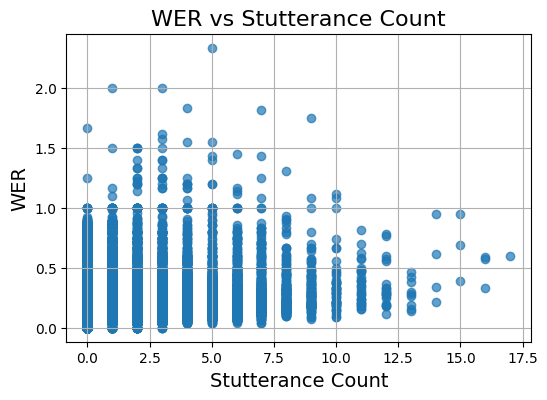

In [16]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wenet["Stutterance_Count"], 
    net_aigenerated_data_wenet["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

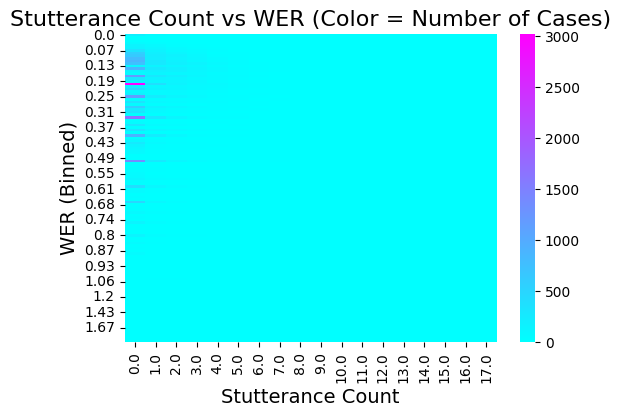

In [17]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

net_aigenerated_data_wenet['WER_Binned'] = np.round(net_aigenerated_data_wenet['WER'], 2)

grouped_data = net_aigenerated_data_wenet.groupby(
    ['Stutterance_Count', 'WER_Binned']
).size().reset_index(name='Count')
heatmap_data = grouped_data.pivot(index='WER_Binned', columns='Stutterance_Count', values='Count').fillna(0)

plt.figure(figsize=(6, 4))
sns.heatmap(
    heatmap_data, cmap='cool', annot=False, fmt='g', cbar=True
)

plt.title("Stutterance Count vs WER (Color = Number of Cases)", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("WER (Binned)", fontsize=14)

plt.show()

In [18]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Stutterance_Count'], net_aigenerated_data_wenet.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 4.15318155648368e-60
rho = -0.08469511105071073


In [17]:
net_aigenerated_data_wenet[["WER", "rougel-f1", "rouge1-f1", "rouge2-f1"]].describe()

,WER,rougel-f1,rouge1-f1,rouge2-f1
count,37148.000000,37148.000000,37148.000000,37148.000000
mean,0.265648,0.683893,0.694439,0.503720
std,0.177740,0.242651,0.243858,0.317447
min,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.571429,0.600000,0.222222
50%,0.200000,0.775510,0.800000,0.615385
75%,0.333333,0.857143,0.872727,0.769231
max,2.333333,1.000000,1.000000,1.000000


***

## ROUGE-N/L Scores (Semantic Evaluation)

In [19]:
from rouge_chinese import Rouge
import jieba

In [20]:
rouge = Rouge()

In [21]:
print_ = True

for index, row in tqdm(net_aigenerated_data_wenet.iterrows(), total=len(net_aigenerated_data_wenet)):
    
    mask_large = (
        (net_aigenerated_data_wenet["Filename"] == row["Filename"]) &
        (net_aigenerated_data_wenet["Start_time"] == row["Start_time"])
    )

    mask_net = (
        (net_data["Filename"] == row["Filename"]) &
        (net_data["Start_time"] == row["Start_time"])
    )

    
    large_row = net_aigenerated_data_wenet.loc[mask_large]
    net_row = net_data.loc[mask_net]

    # print(large_row)
    # print('\n\n\n\n')
    # print(net_row)
    
    if large_row.empty or net_row.empty:
        print("Skipping: One of the rows is empty.")
        continue
        
    wenet = large_row["WeNet"].values[0]
    cleaned_transcript = net_row["Cleaned_Transcript"].values[0]
    
    if pd.isna(wenet) or not isinstance(wenet, str):
        print("Skipping due to missing or non-string WeNet.")
        continue
    if pd.isna(cleaned_transcript) or not isinstance(cleaned_transcript, str):
        print("Skipping due to missing or non-string Cleaned_Transcript.")
        continue

    try:
        
        scores = rouge.get_scores(' '.join(jieba.cut(wenet)), ' '.join(jieba.cut(cleaned_transcript)))
        
        net_aigenerated_data_wenet.loc[mask_large, "rouge1-precision"] = scores[0]["rouge-1"]["p"]
        net_aigenerated_data_wenet.loc[mask_large, "rouge1-recall"] = scores[0]["rouge-1"]["r"]
        net_aigenerated_data_wenet.loc[mask_large, "rouge1-f1"] = scores[0]["rouge-1"]["f"]
        
        
        net_aigenerated_data_wenet.loc[mask_large, "rouge2-precision"] = scores[0]["rouge-2"]["p"]
        net_aigenerated_data_wenet.loc[mask_large, "rouge2-recall"] = scores[0]["rouge-2"]["r"]
        net_aigenerated_data_wenet.loc[mask_large, "rouge2-f1"] = scores[0]["rouge-2"]["f"]
        
        
        net_aigenerated_data_wenet.loc[mask_large, "rougel-precision"] = scores[0]["rouge-l"]["p"]
        net_aigenerated_data_wenet.loc[mask_large, "rougel-recall"] = scores[0]["rouge-l"]["r"]
        net_aigenerated_data_wenet.loc[mask_large, "rougel-f1"] = scores[0]["rouge-l"]["f"]
        
        stutterance_count = net_row["Stutterance_Count"].values[0]
        net_aigenerated_data_wenet.loc[mask_large, "Stutterance_Count"] = stutterance_count

        if (print_):
            print(net_aigenerated_data_wenet)
            print_ = False
        
        # Verify assignment
        # print(f'Assigned Stutterance_Count: {stutterance_count}')
        # print(net_aigenerated_data_wenet.loc[mask_large, "Stutterance_Count"])

    except Exception as e:
        print(f'ERROR: {e}')
        print('Occurred with the following data:')
        print(large_row)
        print(net_row)

  0%|          | 0/37253 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/296134.1.ood/jieba.cache
Loading model cost 0.635 seconds.
Prefix dict has been built successfully.
  0%|          | 15/37253 [00:00<24:15, 25.59it/s] 

       Unnamed: 0 Filename   Start_time     End_time  \
0               0  D0001_A  2081.540000  2109.650000   
1               1  D0001_A   790.130000   796.580000   
2               2  D0001_A  1562.083518  1586.220000   
3               3  D0001_A  2016.780000  2035.673559   
4               4  D0001_A  1682.670000  1709.110000   
...           ...      ...          ...          ...   
37248       37248    P0070  2586.616000  2589.346000   
37249       37249    P0070  2782.496000  2783.706000   
37250       37250    P0070  2995.296000  2998.116000   
37251       37251    P0070  2604.066000  2606.656000   
37252       37252    P0070  2434.606000  2436.576000   

                                                   WeNet       WER  \
0      我说出来就比较地需要时间然后那个识别的他的不就是他等你一会你那个话还没有说完的还没有说出来的...  0.226804   
1                                              第四句有我我说的话  0.500000   
2      这部剧是不怎么评分是不怎么好的就因为评评论区的那那些人他们都在说拿到号做好惨的那个就那么勤奋...  0.203125   
3                        很精准对讯飞语音还是讯飞助手来着就我记得他是

  2%|▏         | 709/37253 [00:05<04:23, 138.51it/s]

Skipping due to missing or non-string WeNet.


  4%|▎         | 1351/37253 [00:10<04:23, 136.44it/s]

Skipping due to missing or non-string WeNet.


  4%|▍         | 1450/37253 [00:11<04:21, 136.93it/s]

Skipping due to missing or non-string WeNet.


  5%|▍         | 1853/37253 [00:14<04:13, 139.82it/s]

Skipping due to missing or non-string WeNet.
Skipping: One of the rows is empty.


  6%|▌         | 2165/37253 [00:16<04:10, 139.98it/s]

Skipping due to missing or non-string WeNet.


  6%|▌         | 2207/37253 [00:16<04:15, 137.39it/s]

Skipping due to missing or non-string WeNet.


  7%|▋         | 2726/37253 [00:20<04:16, 134.87it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 10%|█         | 3825/37253 [00:28<03:56, 141.16it/s]

Skipping due to missing or non-string WeNet.


 11%|█         | 4050/37253 [00:30<03:52, 142.88it/s]

Skipping due to missing or non-string WeNet.


 11%|█         | 4080/37253 [00:30<03:52, 142.68it/s]

Skipping due to missing or non-string WeNet.


 11%|█         | 4125/37253 [00:30<03:51, 143.20it/s]

Skipping due to missing or non-string WeNet.


 12%|█▏        | 4444/37253 [00:33<03:47, 144.00it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 12%|█▏        | 4605/37253 [00:34<03:54, 139.16it/s]

Skipping due to missing or non-string WeNet.


 13%|█▎        | 4766/37253 [00:35<03:49, 141.25it/s]

Skipping due to missing or non-string WeNet.


 14%|█▎        | 5105/37253 [00:37<03:47, 141.58it/s]

Skipping due to missing or non-string WeNet.


 14%|█▍        | 5236/37253 [00:38<03:53, 137.16it/s]

Skipping due to missing or non-string WeNet.


 14%|█▍        | 5279/37253 [00:39<03:52, 137.74it/s]

Skipping due to missing or non-string WeNet.


 14%|█▍        | 5335/37253 [00:39<03:55, 135.43it/s]

Skipping due to missing or non-string WeNet.


 16%|█▌        | 5804/37253 [00:42<03:51, 135.96it/s]

Skipping due to missing or non-string WeNet.


 16%|█▌        | 5918/37253 [00:43<03:43, 140.34it/s]

Skipping due to missing or non-string WeNet.


 17%|█▋        | 6251/37253 [00:46<03:37, 142.58it/s]

Skipping due to missing or non-string WeNet.


 17%|█▋        | 6296/37253 [00:46<03:39, 140.85it/s]

Skipping due to missing or non-string WeNet.


 18%|█▊        | 6756/37253 [00:49<03:39, 138.68it/s]

Skipping due to missing or non-string WeNet.


 19%|█▉        | 7152/37253 [00:52<03:29, 144.02it/s]

Skipping due to missing or non-string WeNet.


 19%|█▉        | 7242/37253 [00:53<03:34, 140.01it/s]

Skipping due to missing or non-string WeNet.


 20%|██        | 7497/37253 [00:55<03:33, 139.43it/s]

Skipping due to missing or non-string WeNet.


 20%|██        | 7539/37253 [00:55<03:33, 139.11it/s]

Skipping due to missing or non-string WeNet.


 21%|██        | 7903/37253 [00:58<03:30, 139.71it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8120/37253 [00:59<03:23, 143.00it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8210/37253 [01:00<03:25, 141.64it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8240/37253 [01:00<03:24, 141.60it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 22%|██▏       | 8300/37253 [01:00<03:26, 140.19it/s]

Skipping due to missing or non-string WeNet.


 22%|██▏       | 8360/37253 [01:01<03:23, 141.91it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 23%|██▎       | 8404/37253 [01:01<03:26, 139.69it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 23%|██▎       | 8521/37253 [01:02<03:20, 143.16it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 23%|██▎       | 8624/37253 [01:03<03:25, 139.31it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 24%|██▎       | 8794/37253 [01:04<03:27, 136.88it/s]

Skipping due to missing or non-string WeNet.


 24%|██▍       | 8851/37253 [01:04<03:27, 136.94it/s]

Skipping due to missing or non-string WeNet.


 24%|██▍       | 9034/37253 [01:06<03:25, 137.08it/s]

Skipping due to missing or non-string WeNet.


 25%|██▌       | 9380/37253 [01:08<03:23, 136.66it/s]

Skipping due to missing or non-string WeNet.


 28%|██▊       | 10308/37253 [01:15<03:09, 142.15it/s]

Skipping due to missing or non-string WeNet.


 28%|██▊       | 10486/37253 [01:16<03:13, 138.38it/s]

Skipping: One of the rows is empty.


 29%|██▉       | 10865/37253 [01:19<03:05, 141.92it/s]

Skipping due to missing or non-string WeNet.


 29%|██▉       | 10984/37253 [01:20<03:05, 141.48it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 30%|███       | 11283/37253 [01:22<03:05, 140.05it/s]

Skipping due to missing or non-string WeNet.


 31%|███       | 11592/37253 [01:24<03:04, 139.25it/s]

Skipping due to missing or non-string WeNet.


 33%|███▎      | 12160/37253 [01:28<02:58, 140.50it/s]

Skipping due to missing or non-string WeNet.


 33%|███▎      | 12220/37253 [01:29<02:56, 141.53it/s]

Skipping due to missing or non-string WeNet.


 33%|███▎      | 12250/37253 [01:29<02:55, 142.31it/s]

Skipping due to missing or non-string WeNet.


 33%|███▎      | 12310/37253 [01:29<02:57, 140.16it/s]

Skipping due to missing or non-string WeNet.


 34%|███▍      | 12728/37253 [01:32<02:55, 139.89it/s]

Skipping due to missing or non-string WeNet.


 35%|███▍      | 12961/37253 [01:34<02:53, 139.62it/s]

Skipping due to missing or non-string WeNet.


 35%|███▌      | 13103/37253 [01:35<02:54, 138.10it/s]

Skipping due to missing or non-string WeNet.


 35%|███▌      | 13160/37253 [01:36<02:57, 135.47it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 36%|███▌      | 13273/37253 [01:36<02:51, 139.68it/s]

Skipping due to missing or non-string WeNet.


 38%|███▊      | 13990/37253 [01:41<02:49, 137.65it/s]

Skipping due to missing or non-string WeNet.


 38%|███▊      | 14109/37253 [01:42<02:41, 143.15it/s]

Skipping due to missing or non-string WeNet.


 38%|███▊      | 14214/37253 [01:43<02:41, 142.82it/s]

Skipping due to missing or non-string WeNet.


 39%|███▊      | 14393/37253 [01:44<02:42, 140.56it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 40%|███▉      | 14743/37253 [01:47<02:39, 141.23it/s]

Skipping due to missing or non-string WeNet.


 42%|████▏     | 15659/37253 [01:53<02:27, 146.70it/s]

Skipping due to missing or non-string WeNet.


 45%|████▍     | 16617/37253 [02:00<02:30, 137.54it/s]

Skipping due to missing or non-string WeNet.


 47%|████▋     | 17495/37253 [02:06<02:15, 145.92it/s]

Skipping due to missing or non-string WeNet.


 48%|████▊     | 17870/37253 [02:09<02:13, 145.62it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 48%|████▊     | 17900/37253 [02:09<02:14, 144.31it/s]

Skipping due to missing or non-string WeNet.


 48%|████▊     | 18020/37253 [02:10<02:13, 143.65it/s]

Skipping due to missing or non-string WeNet.


 51%|█████     | 19082/37253 [02:17<02:13, 135.72it/s]

Skipping due to missing or non-string WeNet.


 51%|█████▏    | 19126/37253 [02:17<02:09, 140.20it/s]

Skipping due to missing or non-string WeNet.


 52%|█████▏    | 19261/37253 [02:18<02:03, 145.51it/s]

Skipping due to missing or non-string WeNet.


 54%|█████▎    | 20001/37253 [02:24<01:59, 144.10it/s]

Skipping due to missing or non-string WeNet.


 57%|█████▋    | 21276/37253 [02:33<01:48, 147.18it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 57%|█████▋    | 21306/37253 [02:33<01:48, 146.62it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21546/37253 [02:34<01:47, 146.34it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21606/37253 [02:35<01:47, 145.03it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21696/37253 [02:35<01:46, 145.83it/s]

Skipping due to missing or non-string WeNet.


 58%|█████▊    | 21741/37253 [02:36<01:47, 144.29it/s]

Skipping due to missing or non-string WeNet.


 63%|██████▎   | 23420/37253 [02:47<01:36, 144.09it/s]

Skipping due to missing or non-string WeNet.


 66%|██████▋   | 24717/37253 [02:57<01:26, 144.65it/s]

Skipping due to missing or non-string WeNet.


 67%|██████▋   | 24852/37253 [02:58<01:26, 142.81it/s]

Skipping due to missing or non-string WeNet.


 67%|██████▋   | 25077/37253 [02:59<01:25, 141.66it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 81%|████████  | 30111/37253 [03:34<00:50, 140.69it/s]

Skipping due to missing or non-string WeNet.


 81%|████████  | 30246/37253 [03:35<00:47, 146.11it/s]

Skipping due to missing or non-string WeNet.
Skipping due to missing or non-string WeNet.


 82%|████████▏ | 30364/37253 [03:36<00:51, 134.46it/s]

Skipping due to missing or non-string WeNet.


 82%|████████▏ | 30707/37253 [03:39<00:45, 145.31it/s]

Skipping due to missing or non-string WeNet.


 83%|████████▎ | 30752/37253 [03:39<00:45, 141.83it/s]

Skipping due to missing or non-string WeNet.


 91%|█████████▏| 34063/37253 [04:02<00:21, 145.14it/s]

Skipping: One of the rows is empty.


 92%|█████████▏| 34108/37253 [04:02<00:21, 144.06it/s]

Skipping: One of the rows is empty.


 93%|█████████▎| 34603/37253 [04:06<00:18, 145.79it/s]

Skipping: One of the rows is empty.


100%|██████████| 37253/37253 [04:24<00:00, 140.76it/s]


In [22]:
net_aigenerated_data_wenet

,Unnamed: 0,Filename,Start_time,End_time,WeNet,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,WER_Binned,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1
0,0,D0001_A,2081.540000,2109.650000,我说出来就比较地需要时间然后那个识别的他的不就是他等你一会你那个话还没有说完的还没有说出来的...,0.226804,1.0,100,0,0.23,0.837838,0.815789,0.826667,0.555556,0.491803,0.521739,0.803279,0.700000,0.748092
1,1,D0001_A,790.130000,796.580000,第四句有我我说的话,0.500000,1.0,100,0,0.50,0.800000,0.571429,0.666667,0.400000,0.333333,0.363636,0.666667,0.571429,0.615385
2,2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评分是不怎么好的就因为评评论区的那那些人他们都在说拿到号做好惨的那个就那么勤奋...,0.203125,10.0,100,0,0.20,0.806452,0.806452,0.806452,0.617647,0.525000,0.567568,0.828571,0.690476,0.753247
3,3,D0001_A,2016.780000,2035.673559,很精准对讯飞语音还是讯飞助手来着就我记得他是叫讯飞我之前就是他,0.210526,7.0,100,0,0.21,0.888889,0.800000,0.842105,0.650000,0.464286,0.541667,0.863636,0.612903,0.716981
4,4,D0001_A,1682.670000,1709.110000,一个个是叫啥来的我忘了就是出现了这一个人然后呢他他就射了一把剑然后就就把那个拿二号给长杀了就...,0.250000,8.0,100,0,0.25,0.806452,0.757576,0.781250,0.512821,0.454545,0.481928,0.761905,0.653061,0.703297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,100,0,0.09,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091
37249,37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,100,0,0.17,1.000000,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143
37250,37250,P0070,2995.296000,2998.116000,你好米娅今天柴油价怎么样,0.266667,0.0,100,0,0.27,0.833333,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667
37251,37251,P0070,2604.066000,2606.656000,单曲循环歌曲琉璃光之歌,0.083333,0.0,100,0,0.08,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091


In [23]:
net_aigenerated_data_wenet.to_csv('net_aigenerated_data_wenet_performance_stu.csv', sep=',')

***

## Visualization of Relationship between Stuttering Count and Rouge Scores

In [6]:
## Load data from csv if starting here

net_aigenerated_data_wenet = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wenet/net_aigenerated_data_wenet_performance_stu.csv', delimiter=',')

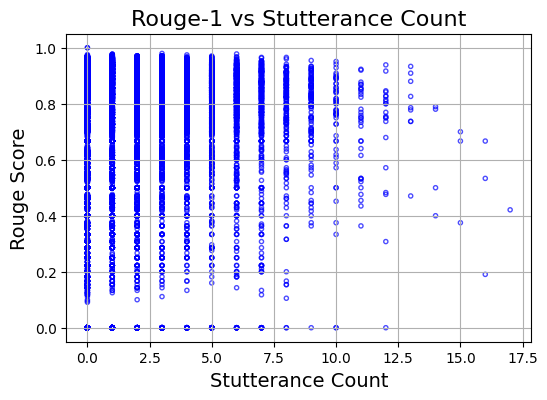

In [9]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wenet["Stutterance_Count"], 
#     net_aigenerated_data_wenet["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wenet["Stutterance_Count"], 
#     net_aigenerated_data_wenet["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wenet["Stutterance_Count"], 
    net_aigenerated_data_wenet["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

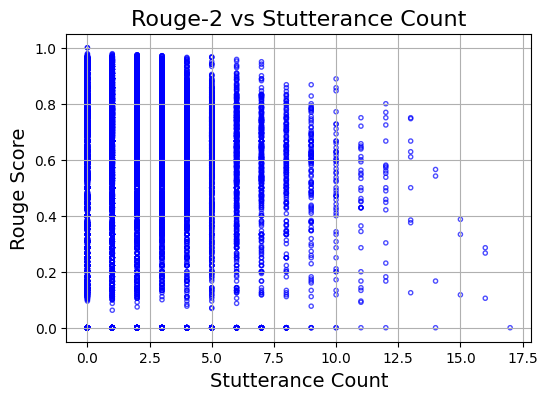

In [12]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wenet["Stutterance_Count"], 
#     net_aigenerated_data_wenet["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wenet["Stutterance_Count"], 
#     net_aigenerated_data_wenet["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wenet["Stutterance_Count"], 
    net_aigenerated_data_wenet["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

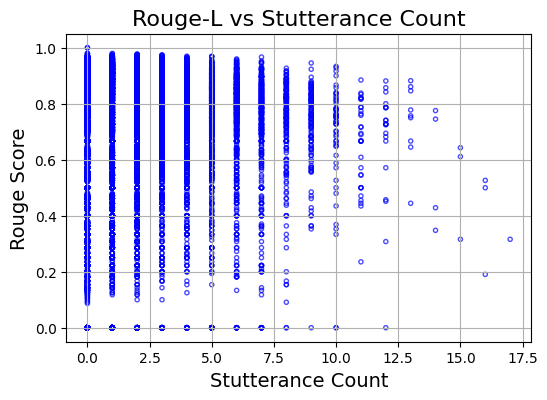

In [15]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wenet["Stutterance_Count"], 
#     net_aigenerated_data_wenet["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wenet["Stutterance_Count"], 
#     net_aigenerated_data_wenet["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wenet["Stutterance_Count"], 
    net_aigenerated_data_wenet["rougel-f1"], 
    facecolors="none", edgecolors='b',
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Stutterance Count", fontsize=16)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.show()

## Correlations between Stuttering and Rouge Scores

In [16]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Stutterance_Count'], net_aigenerated_data_wenet.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")

rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Stutterance_Count'], net_aigenerated_data_wenet.dropna()['rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")

rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Stutterance_Count'], net_aigenerated_data_wenet.dropna()['rougel-f1'])
print(f"p-value [stuttering count & rouge-l f1] = {p}")
print(f"rho [stuttering count & rouge-l f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.21527309202876885
p-value [stuttering count & rouge-2 f1] = 3.693334793086846e-135
rho [stuttering count & rouge-2 f1] = 0.12785307221499698
p-value [stuttering count & rouge-l f1] = 6.48359802224591e-206
rho [stuttering count & rouge-l f1] = 0.15788019321213467
